0. Install Package

In [ ]:
!pip install snntorch
acc_log = {}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 12.3 MB/s eta 0:00:00


1. TTFS_MNIST

In [ ]:
# TTFS-SNN on MNIST with snnTorch
# Tested structure: TTFS (latency) encoding -> FC -> LIF -> FC -> LIF(readout)
# Loss: CrossEntropy on final-time membrane of readout layer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import snntorch as snn
from snntorch import spikegen

# -----------------------------
# Config
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 128
num_epochs = 30
lr = 1e-3

T = 25                 # number of time steps for TTFS window
tau = 2.0              # LIF decay time constant surrogate parameter (via beta below)
beta = torch.exp(torch.tensor(-1.0 / tau)).item()  # beta in (0,1), bigger -> slower decay

hidden = 512
num_classes = 10

# -----------------------------
# Data
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
])

train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

# -----------------------------
# Model
# -----------------------------
class TTFS_MNIST_SNN(nn.Module):
    def __init__(self, in_dim=28*28, hidden_dim=512, out_dim=10, beta=0.95):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, spk_in):
        """
        spk_in: [T, B, in_dim]  (TTFS encoded spikes)
        Returns:
          spk2_rec: [T, B, out_dim]
          mem2_rec: [T, B, out_dim]
        """
        Tsteps, B, _ = spk_in.shape

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []
        mem2_rec = []

        for t in range(Tsteps):
            cur1 = self.fc1(spk_in[t])
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        spk2_rec = torch.stack(spk2_rec, dim=0)
        mem2_rec = torch.stack(mem2_rec, dim=0)
        return spk2_rec, mem2_rec


model = TTFS_MNIST_SNN(hidden_dim=hidden, out_dim=num_classes, beta=beta).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# -----------------------------
# TTFS Encoder
# -----------------------------
def ttfs_encode(x_img, T):
    """
    x_img: [B, 1, 28, 28] in [0,1]
    Return: spikes [T, B, 784]
    TTFS/latency coding: higher intensity -> earlier spike time (single spike max)
    """
    x = x_img.view(x_img.size(0), -1)  # [B, 784]

    # snnTorch latency coding:
    # - Each input neuron fires at most once in [0, T-1]
    # - Larger x -> earlier spike
    # normalize=True expects x in [0,1]
    spk = spikegen.latency(x, num_steps=T, normalize=True)  # [T, B, 784]
    return spk

# -----------------------------
# Train / Eval
# -----------------------------
def accuracy_from_logits(logits, y):
    # logits: [B, 10]
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

@torch.no_grad()
def evaluate():
    model.eval()
    total_acc = 0.0
    total_n = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        spk_in = ttfs_encode(x, T).to(device)

        spk_out, mem_out = model(spk_in)
        logits = mem_out[-1]  # final time membrane as class score

        bsz = x.size(0)
        total_acc += accuracy_from_logits(logits, y) * bsz
        total_n += bsz
    return total_acc / max(total_n, 1)

encoder_name = "TTFS"
acc_log[encoder_name] = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    seen = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        spk_in = ttfs_encode(x, T).to(device)

        spk_out, mem_out = model(spk_in)
        logits = mem_out[-1]  # [B, 10]

        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        bsz = x.size(0)
        running_loss += loss.item() * bsz
        running_acc += accuracy_from_logits(logits, y) * bsz
        seen += bsz

    test_acc = evaluate()
    acc_log[encoder_name].append(test_acc)
    print(f"Epoch {epoch:02d} | "
          f"train loss {running_loss/seen:.4f} | train acc {running_acc/seen:.4f} | test acc {test_acc:.4f}")

print("Done.")


100%|██████████| 9.91M/9.91M [00:00<00:00, 14.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 343kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]


Epoch 01 | train loss 0.4233 | train acc 0.8783 | test acc 0.9197
Epoch 02 | train loss 0.2480 | train acc 0.9263 | test acc 0.9369
Epoch 03 | train loss 0.2095 | train acc 0.9385 | test acc 0.9388
Epoch 04 | train loss 0.1857 | train acc 0.9454 | test acc 0.9492
Epoch 05 | train loss 0.1687 | train acc 0.9506 | test acc 0.9520
Epoch 06 | train loss 0.1629 | train acc 0.9520 | test acc 0.9547
Epoch 07 | train loss 0.1515 | train acc 0.9561 | test acc 0.9565
Epoch 08 | train loss 0.1445 | train acc 0.9572 | test acc 0.9567
Epoch 09 | train loss 0.1364 | train acc 0.9593 | test acc 0.9522
Epoch 10 | train loss 0.1315 | train acc 0.9608 | test acc 0.9550
Epoch 11 | train loss 0.1281 | train acc 0.9614 | test acc 0.9604
Epoch 12 | train loss 0.1228 | train acc 0.9637 | test acc 0.9506
Epoch 13 | train loss 0.1215 | train acc 0.9639 | test acc 0.9581
Epoch 14 | train loss 0.1163 | train acc 0.9647 | test acc 0.9552
Epoch 15 | train loss 0.1145 | train acc 0.9648 | test acc 0.9561
Epoch 16 |

2. Rate_MNIST

In [ ]:
# Rate-Encoding SNN on MNIST with snnTorch
# Encoding: Poisson(rate) spikes over T steps
# Readout: spike count over time -> logits -> CrossEntropy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import snntorch as snn
from snntorch import spikegen

# -----------------------------
# Config
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 128
num_epochs = 30
lr = 1e-3

T = 20                 # time steps
tau = 2.0
beta = torch.exp(torch.tensor(-1.0 / tau)).item()

hidden = 512
num_classes = 10

# -----------------------------
# Data
# -----------------------------
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

# -----------------------------
# Model
# -----------------------------
class Rate_MNIST_SNN(nn.Module):
    def __init__(self, in_dim=28*28, hidden_dim=512, out_dim=10, beta=0.95):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, spk_in):
        """
        spk_in: [T, B, in_dim]
        Returns:
          spk2_rec: [T, B, out_dim]
          mem2_rec: [T, B, out_dim]
        """
        Tsteps, B, _ = spk_in.shape
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec, mem2_rec = [], []

        for t in range(Tsteps):
            cur1 = self.fc1(spk_in[t])
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, 0), torch.stack(mem2_rec, 0)

model = Rate_MNIST_SNN(hidden_dim=hidden, out_dim=num_classes, beta=beta).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# -----------------------------
# Rate (Poisson) Encoder
# -----------------------------
def rate_encode(x_img, T):
    """
    x_img: [B, 1, 28, 28] in [0,1]
    Returns spikes: [T, B, 784]
    Poisson(rate) encoding: higher intensity -> higher spike probability each step
    """
    x = x_img.view(x_img.size(0), -1)  # [B, 784]
    spk = spikegen.rate(x, num_steps=T)  # [T, B, 784]
    return spk

# -----------------------------
# Train / Eval
# -----------------------------
@torch.no_grad()
def evaluate():
    model.eval()
    correct = 0
    total = 0

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        spk_in = rate_encode(x, T).to(device)

        spk_out, _ = model(spk_in)

        # spike count over time as logits
        logits = spk_out.sum(dim=0)  # [B, 10]
        pred = logits.argmax(dim=1)

        correct += (pred == y).sum().item()
        total += y.numel()

    return correct / max(total, 1)

encoder_name = "Rate"
acc_log[encoder_name] = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        spk_in = rate_encode(x, T).to(device)

        spk_out, _ = model(spk_in)

        logits = spk_out.sum(dim=0)  # [B, 10]
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)

    test_acc = evaluate()
    acc_log[encoder_name].append(test_acc)
    print(f"Epoch {epoch:02d} | train loss {total_loss/total:.4f} | train acc {total_correct/total:.4f} | test acc {test_acc:.4f}")

print("Done.")


Epoch 01 | train loss 0.2591 | train acc 0.9203 | test acc 0.9631
Epoch 02 | train loss 0.0913 | train acc 0.9714 | test acc 0.9726
Epoch 03 | train loss 0.0547 | train acc 0.9827 | test acc 0.9749
Epoch 04 | train loss 0.0384 | train acc 0.9869 | test acc 0.9789
Epoch 05 | train loss 0.0332 | train acc 0.9893 | test acc 0.9754
Epoch 06 | train loss 0.0260 | train acc 0.9912 | test acc 0.9751
Epoch 07 | train loss 0.0227 | train acc 0.9924 | test acc 0.9774
Epoch 08 | train loss 0.0221 | train acc 0.9924 | test acc 0.9792
Epoch 09 | train loss 0.0164 | train acc 0.9943 | test acc 0.9804
Epoch 10 | train loss 0.0178 | train acc 0.9938 | test acc 0.9806
Epoch 11 | train loss 0.0134 | train acc 0.9954 | test acc 0.9796
Epoch 12 | train loss 0.0163 | train acc 0.9942 | test acc 0.9763
Epoch 13 | train loss 0.0134 | train acc 0.9954 | test acc 0.9812
Epoch 14 | train loss 0.0095 | train acc 0.9968 | test acc 0.9792
Epoch 15 | train loss 0.0126 | train acc 0.9955 | test acc 0.9798
Epoch 16 |

3. ISI_MNIST

In [ ]:
# MNIST SNN with Fixed-Spike-Count ISI Encoder (deterministic)
# Encoder guarantees: each input neuron fires exactly K spikes per encoding window.
# Network: FC -> LIF -> FC -> LIF(readout)
# Loss: CrossEntropy on spike-count logits (sum over time)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import snntorch as snn

# -----------------------------
# Config
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 128
num_epochs = 30
lr = 1e-3

T = 80          # encoding window length (time steps)
K = 6           # FIXED spike count per input neuron per window
alpha_max = 2.0 # controls ISI skew strength (larger -> more skew)

tau = 2.0
beta = torch.exp(torch.tensor(-1.0 / tau)).item()

hidden = 512
num_classes = 10

# -----------------------------
# Data
# -----------------------------
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, drop_last=False)

# -----------------------------
# Fixed-spike-count ISI Encoder
# -----------------------------
def isi_fixed_spikecount_encode(x_img: torch.Tensor, T: int, K: int, alpha_max: float = 2.0):
    """
    Deterministic fixed-spike-count ISI encoder.

    Inputs:
      x_img: [B, 1, 28, 28] in [0,1]
      T: number of time steps
      K: exact spike count per neuron per window (K>=1, requires K<=T)
      alpha_max: skew strength

    Output:
      spk: [T, B, 784] in {0,1}
    """
    assert T >= 2
    assert K >= 1
    if K > T:
        raise ValueError(f"K={K} must satisfy K<=T={T}.")

    device = x_img.device
    B = x_img.size(0)
    x = x_img.view(B, -1).clamp(0.0, 1.0)  # [B, N]
    N = x.size(1)

    spk = torch.zeros(T, B, N, device=device)

    if K == 1:
        spk[0] = 1.0
        return spk

    L = K - 1  # number of intervals
    j = torch.arange(L, device=device, dtype=torch.float32).view(1, 1, L)
    mid = (L - 1) / 2.0

    # alpha in [-alpha_max, +alpha_max]
    alpha = (x * 2.0 - 1.0) * alpha_max   # [B, N]
    alpha = alpha.unsqueeze(-1)           # [B, N, 1]

    # positive weights -> normalized
    w = torch.exp(alpha * (j - mid))      # [B, N, L]
    w = w / (w.sum(dim=-1, keepdim=True) + 1e-12)

    # target real intervals sum to (T-1)
    d_real = w * float(T - 1)             # [B, N, L]

    # integer intervals, each >=1
    d = torch.round(d_real).long().clamp(min=1)  # [B, N, L]

    # correct rounding drift by adjusting last interval
    diff = (T - 1) - d.sum(dim=-1)        # [B, N]
    d[..., -1] = (d[..., -1] + diff).clamp(min=1)

    # final safety: ensure exact sum (T-1)
    residual = (T - 1) - d.sum(dim=-1)    # [B, N]

    add_mask = residual > 0
    if add_mask.any():
        d[add_mask, -1] += residual[add_mask]

    sub_mask = residual < 0
    if sub_mask.any():
        need = (-residual[sub_mask]).clone()
        d_sub = d[sub_mask]
        for col in range(L - 1, -1, -1):
            room = (d_sub[:, col] - 1).clamp(min=0)
            take = torch.minimum(room, need)
            d_sub[:, col] -= take
            need -= take
            if (need == 0).all():
                break
        d[sub_mask] = d_sub

    # spike times: t0=0, next are cumulative sums of intervals
    t = torch.zeros(B, N, K, device=device, dtype=torch.long)
    t[..., 1:] = torch.cumsum(d, dim=-1)          # last should be T-1
    t = t.clamp(0, T - 1)

    # write spikes
    b_idx = torch.arange(B, device=device).view(B, 1, 1).expand(B, N, K)
    n_idx = torch.arange(N, device=device).view(1, N, 1).expand(B, N, K)
    spk[t, b_idx, n_idx] = 1.0

    return spk

# -----------------------------
# Model
# -----------------------------
class FixedISI_MNIST_SNN(nn.Module):
    def __init__(self, in_dim=28*28, hidden_dim=512, out_dim=10, beta=0.95):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, spk_in):
        """
        spk_in: [T, B, in_dim]
        return: spk2_rec [T, B, out_dim]
        """
        Tsteps, B, _ = spk_in.shape
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []

        for t in range(Tsteps):
            cur1 = self.fc1(spk_in[t])
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)

        return torch.stack(spk2_rec, dim=0)

model = FixedISI_MNIST_SNN(hidden_dim=hidden, out_dim=num_classes, beta=beta).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# -----------------------------
# Train / Eval
# -----------------------------
@torch.no_grad()
def evaluate():
    model.eval()
    correct = 0
    total = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        spk_in = isi_fixed_spikecount_encode(x, T=T, K=K, alpha_max=alpha_max)

        spk_out = model(spk_in)
        logits = spk_out.sum(dim=0)  # spike-count readout: [B,10]
        pred = logits.argmax(dim=1)

        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(total, 1)

# quick sanity check: fixed spike count
@torch.no_grad()
def sanity_check_fixed_count():
    x, _ = next(iter(train_loader))
    x = x.to(device)
    spk = isi_fixed_spikecount_encode(x, T=T, K=K, alpha_max=alpha_max)  # [T,B,784]
    counts = spk.sum(dim=0)  # [B,784]
    print("Fixed-count check (min,max) =", counts.min().item(), counts.max().item())

sanity_check_fixed_count()

encoder_name = "ISI"
acc_log[encoder_name] = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        spk_in = isi_fixed_spikecount_encode(x, T=T, K=K, alpha_max=alpha_max)

        spk_out = model(spk_in)
        logits = spk_out.sum(dim=0)

        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)

    test_acc = evaluate()
    acc_log[encoder_name].append(test_acc)
    print(f"Epoch {epoch:02d} | train loss {total_loss/total:.4f} | train acc {total_correct/total:.4f} | test acc {test_acc:.4f}")

print("Done.")



Fixed-count check (min,max) = 6.0 6.0
Epoch 01 | train loss 0.6484 | train acc 0.7860 | test acc 0.9060
Epoch 02 | train loss 0.2471 | train acc 0.9232 | test acc 0.9201
Epoch 03 | train loss 0.1825 | train acc 0.9440 | test acc 0.9492
Epoch 04 | train loss 0.1481 | train acc 0.9544 | test acc 0.9525
Epoch 05 | train loss 0.1225 | train acc 0.9625 | test acc 0.9577
Epoch 06 | train loss 0.1044 | train acc 0.9676 | test acc 0.9639
Epoch 07 | train loss 0.0939 | train acc 0.9702 | test acc 0.9627
Epoch 08 | train loss 0.0791 | train acc 0.9749 | test acc 0.9593
Epoch 09 | train loss 0.0704 | train acc 0.9769 | test acc 0.9671
Epoch 10 | train loss 0.0629 | train acc 0.9795 | test acc 0.9663
Epoch 11 | train loss 0.0543 | train acc 0.9821 | test acc 0.9657
Epoch 12 | train loss 0.0482 | train acc 0.9842 | test acc 0.9635
Epoch 13 | train loss 0.0402 | train acc 0.9868 | test acc 0.9704
Epoch 14 | train loss 0.0377 | train acc 0.9868 | test acc 0.9702
Epoch 15 | train loss 0.0340 | train a

4. TTFS-Phase(Maybe?)_MNIST

In [ ]:
# MNIST SNN with TTFS-Phase encoder (GLOBAL phase lock to SMO maximum)
# Encoder: one spike per input neuron, spike time quantized to t = phi0 + k*P
# Network: FC -> LIF -> FC -> LIF
# Readout: final membrane as logits (CrossEntropy)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import snntorch as snn

# -----------------------------
# Config
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 128
num_epochs = 30
lr = 1e-3

T = 40      # encoding window length
P = 8       # SMO period (time steps)
phi0 = 0    # SMO maximum phase offset in [0, P-1]

tau = 2.0
beta = torch.exp(torch.tensor(-1.0 / tau)).item()

hidden = 512
num_classes = 10

# -----------------------------
# Data
# -----------------------------
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, drop_last=False)

# -----------------------------
# TTFS-Phase (SMO-max locked) Encoder
# -----------------------------
def ttfs_phase_smo_max_encode(x_img, T=40, P=8, phi0=0):
    """
    All neurons fire ONLY at SMO maxima times: t ∈ {phi0 + k*P}.
    Exactly one spike per neuron in the window.
    """
    assert 0 <= phi0 < P, "phi0 must be within [0, P-1]"
    device = x_img.device

    B = x_img.size(0)
    x = x_img.view(B, -1).clamp(0.0, 1.0)  # [B, N]
    N = x.size(1)

    # desired TTFS time (bright earlier)
    t_des = torch.round((1.0 - x) * (T - 1)).long()  # [B, N]

    # choose k so that phi0 + k*P is closest to t_des
    k = torch.round((t_des - phi0).float() / float(P)).long()
    k = torch.clamp(k, min=0)

    t = phi0 + k * P  # [B, N]

    # snap to last valid maxima <= T-1 (keeps strict phase-lock)
    last_valid = phi0 + ((T - 1 - phi0) // P) * P
    t = torch.clamp(t, 0, last_valid)

    spk = torch.zeros(T, B, N, device=device)

    b_idx = torch.arange(B, device=device).unsqueeze(1).expand(B, N)  # [B,N]
    n_idx = torch.arange(N, device=device).unsqueeze(0).expand(B, N)  # [B,N]
    spk[t, b_idx, n_idx] = 1.0

    return spk

# sanity check helper
@torch.no_grad()
def sanity_check_encoder():
    x, _ = next(iter(train_loader))
    x = x.to(device)
    spk = ttfs_phase_smo_max_encode(x, T=T, P=P, phi0=phi0)  # [T,B,784]
    counts = spk.sum(dim=0)  # [B,784]
    print("Spike-count check (min,max) =", counts.min().item(), counts.max().item())  # should be 1,1
    t_spike = spk.argmax(dim=0)  # [B,784]
    print("Phase check unique ((t-phi0)%P) =", ((t_spike - phi0) % P).unique().tolist())  # should be [0]

# -----------------------------
# Model
# -----------------------------
class TTFSPhaseMNIST_SNN(nn.Module):
    def __init__(self, in_dim=28*28, hidden_dim=512, out_dim=10, beta=0.95):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, spk_in):
        """
        spk_in: [T, B, in_dim]
        returns:
          mem2_rec: [T, B, out_dim]
        """
        Tsteps, B, _ = spk_in.shape
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        mem2_rec = []

        for t in range(Tsteps):
            cur1 = self.fc1(spk_in[t])
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            mem2_rec.append(mem2)

        return torch.stack(mem2_rec, dim=0)

model = TTFSPhaseMNIST_SNN(hidden_dim=hidden, out_dim=num_classes, beta=beta).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# -----------------------------
# Train / Eval
# -----------------------------
@torch.no_grad()
def evaluate():
    model.eval()
    correct = 0
    total = 0

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        spk_in = ttfs_phase_smo_max_encode(x, T=T, P=P, phi0=phi0)

        mem_rec = model(spk_in)
        logits = mem_rec[-1]  # final membrane as logits
        pred = logits.argmax(dim=1)

        correct += (pred == y).sum().item()
        total += y.numel()

    return correct / max(total, 1)

# run sanity check once
sanity_check_encoder()

encoder_name = "TTFS-Phase"
acc_log[encoder_name] = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        spk_in = ttfs_phase_smo_max_encode(x, T=T, P=P, phi0=phi0)

        mem_rec = model(spk_in)
        logits = mem_rec[-1]
        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)

    test_acc = evaluate()
    acc_log[encoder_name].append(test_acc)
    print(f"Epoch {epoch:02d} | train loss {total_loss/total:.4f} | train acc {total_correct/total:.4f} | test acc {test_acc:.4f}")

print("Done.")


Spike-count check (min,max) = 1.0 1.0
Phase check unique ((t-phi0)%P) = [0]
Epoch 01 | train loss 1.1191 | train acc 0.6491 | test acc 0.8691
Epoch 02 | train loss 0.4119 | train acc 0.8804 | test acc 0.8936
Epoch 03 | train loss 0.3455 | train acc 0.8981 | test acc 0.9086
Epoch 04 | train loss 0.3143 | train acc 0.9067 | test acc 0.9115
Epoch 05 | train loss 0.2876 | train acc 0.9143 | test acc 0.9142
Epoch 06 | train loss 0.2703 | train acc 0.9208 | test acc 0.9254
Epoch 07 | train loss 0.2514 | train acc 0.9258 | test acc 0.9287
Epoch 08 | train loss 0.2355 | train acc 0.9301 | test acc 0.9351
Epoch 09 | train loss 0.2189 | train acc 0.9350 | test acc 0.9380
Epoch 10 | train loss 0.2044 | train acc 0.9398 | test acc 0.9412
Epoch 11 | train loss 0.1915 | train acc 0.9435 | test acc 0.9450
Epoch 12 | train loss 0.1797 | train acc 0.9473 | test acc 0.9456
Epoch 13 | train loss 0.1706 | train acc 0.9501 | test acc 0.9474
Epoch 14 | train loss 0.1609 | train acc 0.9526 | test acc 0.9508


5. ISI-Phase_MNIST

In [ ]:
# MNIST SNN with Fixed-K ISI-Phase encoder (locked to SMO maxima)
# Encoder guarantees: each input neuron fires EXACTLY K spikes per window,
# and ALL spikes satisfy t = phi0 + m*P (SMO maxima time grid).
# Network: FC -> LIF -> FC -> LIF
# Readout: spike-count logits (sum over time) + CrossEntropy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import snntorch as snn

# -----------------------------
# Config
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 128
num_epochs = 30
lr = 1e-3

T = 80        # encoding window length (time steps)
P = 8         # SMO period in time steps
phi0 = 0      # SMO maxima phase offset in [0, P-1]
K = 6         # FIXED spike count per input neuron per window
alpha_max = 2.0  # controls how strongly intensity skews the ISI pattern on the maxima grid

tau = 2.0
beta = torch.exp(torch.tensor(-1.0 / tau)).item()

hidden = 512
num_classes = 10

# -----------------------------
# Data
# -----------------------------
transform = transforms.Compose([transforms.ToTensor()])

train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, drop_last=False)

# -----------------------------
# Fixed-K ISI-Phase Encoder (SMO maxima locked)
# -----------------------------
def isi_phase_fixedK_encode(x_img: torch.Tensor, T: int, P: int, phi0: int, K: int, alpha_max: float = 2.0):
    """
    Deterministic fixed-spike-count ISI-Phase encoder.

    - All spikes occur ONLY at SMO maxima times: t = phi0 + m*P
    - Each input neuron fires EXACTLY K spikes per encoding window
    - Intensity x controls the ISI "shape" (how intervals are distributed) on the maxima grid

    Inputs:
      x_img: [B,1,28,28] in [0,1]
    Output:
      spk: [T,B,784] in {0,1}
    """
    assert T >= 2
    assert P >= 1
    assert 0 <= phi0 < P
    assert K >= 1
    if K > T:
        raise ValueError("K must be <= T (time steps).")

    device = x_img.device
    B = x_img.size(0)
    x = x_img.view(B, -1).clamp(0.0, 1.0)  # [B,N]
    N = x.size(1)

    # number of maxima slots in the window [0..T-1]
    if phi0 > T - 1:
        raise ValueError("phi0 is outside [0..T-1]. Choose smaller phi0 or larger T.")
    G = (T - 1 - phi0) // P + 1  # count of times {phi0 + mP} within the window

    if K > G:
        raise ValueError(f"K={K} cannot fit: only G={G} maxima slots exist. Need K <= {G}.")

    spk = torch.zeros(T, B, N, device=device)

    # K==1: spike at first maxima
    if K == 1:
        spk[phi0, :, :] = 1.0
        return spk

    # We place K spikes on the maxima grid indices [0..G-1]
    # idx0=0, idx_{K-1}=G-1 by splitting (G-1) into L=K-1 positive integer intervals.
    L = K - 1
    j = torch.arange(L, device=device, dtype=torch.float32).view(1, 1, L)
    mid = (L - 1) / 2.0

    # alpha in [-alpha_max, +alpha_max]
    alpha = (x * 2.0 - 1.0) * alpha_max        # [B,N]
    alpha = alpha.unsqueeze(-1)                # [B,N,1]

    # weights -> normalized
    w = torch.exp(alpha * (j - mid))           # [B,N,L] > 0
    w = w / (w.sum(dim=-1, keepdim=True) + 1e-12)

    # real intervals sum to (G-1) in grid steps
    d_real = w * float(G - 1)                  # [B,N,L]

    # integer intervals, each >=1
    d = torch.round(d_real).long().clamp(min=1)  # [B,N,L]

    # fix rounding drift so sum(d)=G-1 by adjusting last interval
    diff = (G - 1) - d.sum(dim=-1)             # [B,N]
    d[..., -1] = (d[..., -1] + diff).clamp(min=1)

    # final safety: enforce exact sum (G-1)
    residual = (G - 1) - d.sum(dim=-1)         # [B,N]

    add_mask = residual > 0
    if add_mask.any():
        d[add_mask, -1] += residual[add_mask]

    sub_mask = residual < 0
    if sub_mask.any():
        need = (-residual[sub_mask]).clone()
        d_sub = d[sub_mask]
        for col in range(L - 1, -1, -1):
            room = (d_sub[:, col] - 1).clamp(min=0)
            take = torch.minimum(room, need)
            d_sub[:, col] -= take
            need -= take
            if (need == 0).all():
                break
        d[sub_mask] = d_sub

    # grid indices [B,N,K]
    idx = torch.zeros(B, N, K, device=device, dtype=torch.long)
    idx[..., 1:] = torch.cumsum(d, dim=-1)  # last should be G-1

    # map grid index -> real time at maxima
    t = phi0 + idx * P                      # [B,N,K]
    t = t.clamp(0, T - 1)

    # write spikes
    b_idx = torch.arange(B, device=device).view(B, 1, 1).expand(B, N, K)
    n_idx = torch.arange(N, device=device).view(1, N, 1).expand(B, N, K)
    spk[t, b_idx, n_idx] = 1.0

    return spk

# -----------------------------
# Model
# -----------------------------
class ISIPhaseFixedK_MNIST_SNN(nn.Module):
    def __init__(self, in_dim=28*28, hidden_dim=512, out_dim=10, beta=0.95):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, spk_in):
        """
        spk_in: [T,B,784]
        returns: spk_out [T,B,10]
        """
        Tsteps, B, _ = spk_in.shape
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []
        for t in range(Tsteps):
            cur1 = self.fc1(spk_in[t])
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)

        return torch.stack(spk2_rec, dim=0)

model = ISIPhaseFixedK_MNIST_SNN(hidden_dim=hidden, out_dim=num_classes, beta=beta).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# -----------------------------
# Sanity Check
# -----------------------------
@torch.no_grad()
def sanity_check():
    x, _ = next(iter(train_loader))
    x = x.to(device)
    spk = isi_phase_fixedK_encode(x, T=T, P=P, phi0=phi0, K=K, alpha_max=alpha_max)  # [T,B,784]

    counts = spk.sum(dim=0)  # [B,784]
    print("Fixed-K check (min,max) =", counts.min().item(), counts.max().item())  # should be K,K

    # phase residues for ALL spikes
    ts = spk.nonzero(as_tuple=False)[:, 0]  # all spike times
    print("Phase residues unique =", ((ts - phi0) % P).unique().tolist())  # should be [0]

sanity_check()

# -----------------------------
# Train / Eval
# -----------------------------
@torch.no_grad()
def evaluate():
    model.eval()
    correct = 0
    total = 0

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        spk_in = isi_phase_fixedK_encode(x, T=T, P=P, phi0=phi0, K=K, alpha_max=alpha_max)

        spk_out = model(spk_in)
        logits = spk_out.sum(dim=0)  # spike-count logits
        pred = logits.argmax(dim=1)

        correct += (pred == y).sum().item()
        total += y.numel()

    return correct / max(total, 1)

encoder_name = "ISI-Phase"
acc_log[encoder_name] = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        spk_in = isi_phase_fixedK_encode(x, T=T, P=P, phi0=phi0, K=K, alpha_max=alpha_max)

        spk_out = model(spk_in)
        logits = spk_out.sum(dim=0)

        loss = F.cross_entropy(logits, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += x.size(0)

    test_acc = evaluate()
    acc_log[encoder_name].append(test_acc)
    print(f"Epoch {epoch:02d} | train loss {total_loss/total:.4f} | train acc {total_correct/total:.4f} | test acc {test_acc:.4f}")

print("Done.")



Fixed-K check (min,max) = 6.0 6.0
Phase residues unique = [0]
Epoch 01 | train loss 0.6697 | train acc 0.7745 | test acc 0.9281
Epoch 02 | train loss 0.1963 | train acc 0.9404 | test acc 0.9454
Epoch 03 | train loss 0.1400 | train acc 0.9587 | test acc 0.9603
Epoch 04 | train loss 0.1023 | train acc 0.9698 | test acc 0.9629
Epoch 05 | train loss 0.0785 | train acc 0.9761 | test acc 0.9698
Epoch 06 | train loss 0.0623 | train acc 0.9808 | test acc 0.9679
Epoch 07 | train loss 0.0504 | train acc 0.9842 | test acc 0.9693
Epoch 08 | train loss 0.0446 | train acc 0.9866 | test acc 0.9684
Epoch 09 | train loss 0.0344 | train acc 0.9893 | test acc 0.9730
Epoch 10 | train loss 0.0257 | train acc 0.9927 | test acc 0.9717
Epoch 11 | train loss 0.0225 | train acc 0.9935 | test acc 0.9745
Epoch 12 | train loss 0.0184 | train acc 0.9948 | test acc 0.9768
Epoch 13 | train loss 0.0150 | train acc 0.9955 | test acc 0.9764
Epoch 14 | train loss 0.0130 | train acc 0.9966 | test acc 0.9780
Epoch 15 | tra

Compare Accuracies


=== Accuracy comparison per epoch ===
TTFS: ['0.9197', '0.9369', '0.9388', '0.9492', '0.9520', '0.9547', '0.9565', '0.9567', '0.9522', '0.9550', '0.9604', '0.9506', '0.9581', '0.9552', '0.9561', '0.9593', '0.9586', '0.9607', '0.9552', '0.9583', '0.9601', '0.9582', '0.9583', '0.9578', '0.9571', '0.9611', '0.9608', '0.9628', '0.9608', '0.9630']
Rate: ['0.9631', '0.9726', '0.9749', '0.9789', '0.9754', '0.9751', '0.9774', '0.9792', '0.9804', '0.9806', '0.9796', '0.9763', '0.9812', '0.9792', '0.9798', '0.9793', '0.9810', '0.9804', '0.9809', '0.9810', '0.9802', '0.9794', '0.9794', '0.9810', '0.9802', '0.9820', '0.9796', '0.9831', '0.9788', '0.9809']
ISI: ['0.9060', '0.9201', '0.9492', '0.9525', '0.9577', '0.9639', '0.9627', '0.9593', '0.9671', '0.9663', '0.9657', '0.9635', '0.9704', '0.9702', '0.9686', '0.9699', '0.9690', '0.9712', '0.9658', '0.9704', '0.9691', '0.9697', '0.9717', '0.9713', '0.9725', '0.9709', '0.9672', '0.9698', '0.9714', '0.9667']
TTFS-Phase: ['0.8691', '0.8936', '0.9086'

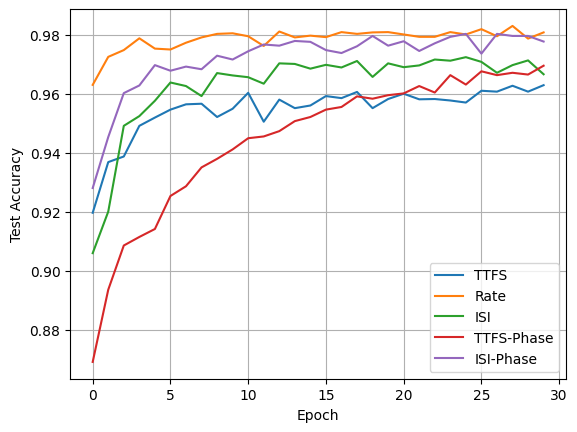

In [ ]:
print("\n=== Accuracy comparison per epoch ===")
for enc, accs in acc_log.items():
    print(f"{enc}: {['%.4f' % a for a in accs]}")

import matplotlib.pyplot as plt

plt.figure()
for enc, accs in acc_log.items():
    plt.plot(accs, label=enc)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

DNN for MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -----------------------------
# Config
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128
epochs = 20
lr = 1e-3

# -----------------------------
# Data
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),                      # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean/std
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# -----------------------------
# Model: plain deep MLP
# -----------------------------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),          # [B, 1, 28, 28] -> [B, 784]
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

model = MLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# -----------------------------
# Train / Eval
# -----------------------------
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss_sum = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item() * x.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return loss_sum / total, correct / total

for epoch in range(1, epochs + 1):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

    train_loss, train_acc = evaluate(model, train_loader)
    test_loss, test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch:02d} | train: loss {train_loss:.4f} acc {train_acc*100:.2f}% "
          f"| test: loss {test_loss:.4f} acc {test_acc*100:.2f}%")

print("Done.")


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Epoch 01 | train: loss 0.1008 acc 96.82% | test: loss 0.1094 acc 96.38%
Epoch 02 | train: loss 0.0627 acc 98.14% | test: loss 0.0876 acc 97.27%
Epoch 03 | train: loss 0.0482 acc 98.52% | test: loss 0.0762 acc 97.58%
Epoch 04 | train: loss 0.0401 acc 98.73% | test: loss 0.0772 acc 97.67%
Epoch 05 | train: loss 0.0313 acc 99.01% | test: loss 0.0710 acc 97.88%
Epoch 06 | train: loss 0.0282 acc 99.13% | test: loss 0.0701 acc 97.93%
Epoch 07 | train: loss 0.0227 acc 99.28% | test: loss 0.0677 acc 98.08%
Epoch 08 | train: loss 0.0197 acc 99.40% | test: loss 0.0705 acc 98.15%
Epoch 09 | train: loss 0.0165 acc 99.47% | test: loss 0.0761 acc 98.09%
Epoch 10 | train: loss 0.0143 acc 99.58% | test: loss 0.0699 acc 98.20%
Epoch 11 | train: loss 0.0124 acc 99.61% | test: loss 0.0705 acc 98.31%
Epoch 12 | train: loss 0.0170 acc 99.48% | test: loss 0.0757 acc 98.01%
Epoch 13 | train: loss 0.0178 acc 99.44% | test: loss 0.0828 acc 97.93%
Epoch 14 | train: loss 0.0130 acc 99.58% | test: loss 0.0751 acc